# Detecting Covid-19 from Chest X-Rays

Train a classification model on chest x-ray images of individuals with covid-19 and those without.

[Dataset source](https://www.kaggle.com/datasets/alifrahman/covid19-chest-xray-image-dataset/)

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [57]:
# import necessary packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# set seed
torch.manual_seed(123)
np.random.seed(123)
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
print(torch.version.cuda)

Using device cuda
11.7


## Loading Data

In [3]:
data_dir = 'data/xray-dataset'

# Basic image to tensor transformation, without normalization
transform=transforms.Compose([transforms.Resize(256),
                             transforms.CenterCrop(224),
                             transforms.ToTensor()])
# Load the dataset
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)
print(dataset.class_to_idx)
_, counts = np.unique(dataset.targets, return_counts=True)
print(counts)

{'covid': 0, 'normal': 1}
[69 25]


In [4]:
# Calculating mean and standard deviation for normalization step
def get_mean_std(dataset):
    channel_means = []
    channel_stds = []
    
    for i in range(len(dataset)):
        image, _ = dataset[i]
        num_channels = image.size(0)
        image = image.view(num_channels, -1)
        channel_means.append(image.mean(dim=1))
        channel_stds.append(image.std(dim=1))

    mean = torch.stack(channel_means).mean(dim=0)
    std = torch.stack(channel_stds).mean(dim=0)
    return mean, std

# Since the dataset is small, use the entire dataset to calculate the mean and std
mean, std = get_mean_std(dataset)
print(mean, std)

tensor([0.5387, 0.5406, 0.5427]) tensor([0.1762, 0.1759, 0.1760])


In [76]:
transform_norm = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean, std)])

norm_dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform_norm)

# Split into 85% training and 20% testing
train_size = int(0.80 * len(dataset))
test_size = len(dataset) - train_size
print(f'training: {train_size}, testing: {test_size}')

train_dataset, test_dataset = torch.utils.data.random_split(norm_dataset, [train_size, test_size])

# Use a WeightedRandomSampler to oversample the minority class
y_train = [dataset.targets[i] for i in train_dataset.indices]
_, train_class_count = np.unique(y_train, return_counts=True)
print(f'training counts by class: covid {train_class_count[0]}, normal {train_class_count[1]}')
class_weight = 1. / train_class_count
print(f'class weights: {class_weight}')
samples_weight = np.array([class_weight[t] for t in y_train])
samples_weight = torch.from_numpy(samples_weight).double()
sampler = WeightedRandomSampler(samples_weight, num_samples=train_size)

# TODO: try training with shuffle vs with sampler
# TODO: can also try replacement=False

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=4)

training: 75, testing: 19
training counts by class: covid 56, normal 19
class weights: [0.01785714 0.05263158]


In [77]:
for batch in test_loader:
    print(batch[0].size())

torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([4, 3, 224, 224])
torch.Size([3, 3, 224, 224])


## Visualizing Images

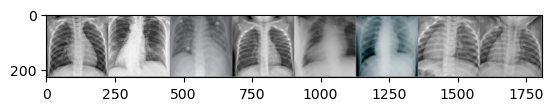

normal covid covid normal covid covid normal normal


In [16]:
def imshow(img):
    inv_normalize = transforms.Normalize(torch.mul(-mean, 1/std), 1/std)
    img = inv_normalize(img)   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('covid', 'normal')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## Training
[Training a Classifier - PyTorch Tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [41]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(186624, 128)
        self.fc2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Model()
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=186624, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)


In [42]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [78]:
num_epochs = 10
    
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.6f}")
print('Finished Training')

save_path = f'./model.pth'
torch.save(model.state_dict(), save_path)

Epoch 1 loss: 0.000302
Epoch 2 loss: 0.000746
Epoch 3 loss: 0.000401
Epoch 4 loss: 0.000409
Epoch 5 loss: 0.000380
Epoch 6 loss: 0.000361
Epoch 7 loss: 0.000294
Epoch 8 loss: 0.000285
Epoch 9 loss: 0.000429
Epoch 10 loss: 0.000469
Finished Training


## Testing

In [80]:
correct, total = 0, 0
with torch.no_grad():
    for (inputs, labels) in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 68 %


In [82]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: covid is 100.0 %
Accuracy for class: normal is 0.0 %


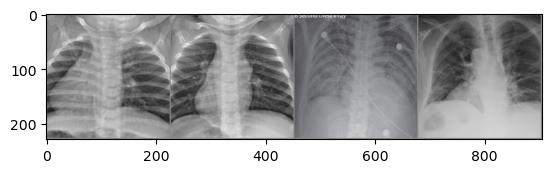

GroundTruth:  normal normal covid covid
Predicted:  covid covid covid covid


In [84]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))